## Relationship between LSTE and ESI and Wildfire Burn Probability

To examine the capability for ECOSTRESS data to understand drought conditions and wildfire risk in Rocky Mountain National Park (RMNP), we will use our LST and ESI data to look at how surface temperatures are related to vegetation drought stress leading up to the extreme wildfires in 2020 on the Front Range.

More intro here.

#### Step 1. Setup the notebook

As before, we need to import the required Python packages and define some environment variables (coordinate systems, file paths). 

In [45]:
import os, glob
import pandas as pd
import numpy as np
import geopandas as gpd
import rioxarray as rxr
import holoviews as hv
import hvplot.xarray
import hvplot.pandas
import folium
import matplotlib.pyplot as plt

from branca.element import Figure

# Projection information
geog = 'EPSG:4326'  # Geographic projection
prj = 'EPSG:5070'  # Projected coordinate system- WGS 84 NAD83 UTM Zone 13N

dest = '/home/jovyan/HYR-SENSE/data/Drought-FireRisk/'

#### Step 2. Read in the data

Now we can read in our ECOSTRESS LST and ESI data from the previous notebook

In [3]:
ecodir = '/home/jovyan/HYR-SENSE/data/Drought-FireRisk/georeferenced'

def list_files(path, ext, recursive):
    """
    List files of a specific type in a directory or subdirectories
    """
    if recursive is True:
        return glob.glob(os.path.join(path, '**', '*{}'.format(ext)), recursive=True)
    else:
        return glob.glob(os.path.join(path, '*{}'.format(ext)), recursive=False)

# Get a list of .nc files
tif_files = list_files(ecodir,"*.tif",recursive=True)
print(tif_files)

['/home/jovyan/HYR-SENSE/data/Drought-FireRisk/georeferenced/ECOL2LSTE/ECOSTRESS_L2_LSTE_11158_004_20200624T121534_0601_01.tif', '/home/jovyan/HYR-SENSE/data/Drought-FireRisk/georeferenced/ECOL2LSTE/ECOSTRESS_L2_LSTE_11406_009_20200710T122818_0601_01.tif', '/home/jovyan/HYR-SENSE/data/Drought-FireRisk/georeferenced/ECO4ESIPTJPL/ECOSTRESS_L4_ESI_PT-JPL_11158_004_20200624T121534_0601_01.tif', '/home/jovyan/HYR-SENSE/data/Drought-FireRisk/georeferenced/ECO4ESIPTJPL/ECOSTRESS_L4_ESI_PT-JPL_11406_009_20200710T122818_0601_01.tif']


In [12]:
### Load our ROI
roi = gpd.read_file(os.path.join(dest, 'NPS_ROMO_Boundary.geojson'))
roi = roi.to_crs("EPSG:4326") # projected CRS
bounds = roi.total_bounds  # Get the bounding box in the format (minx, miny, maxx, maxy)

In [16]:
### Now, read in the raster data and clip to our ROI
# Careful to manage the memory usage here because the original TIF files can be large before clipping

eco_da = []
for fp in tif_files:
    # Load the raster dataset
    da = rxr.open_rasterio(fp, mask=True).squeeze()
    # Crop to the bounds
    crop = da.rio.clip_box(*bounds)
    eco_da.append(crop)
    
    del da

print(eco_da[0])

<xarray.DataArray (y: 629, x: 668)>
[420172 values with dtype=float64]
Coordinates:
    band         int64 1
  * x            (x) float64 -105.9 -105.9 -105.9 ... -105.5 -105.5 -105.5
  * y            (y) float64 40.55 40.55 40.55 40.55 ... 40.16 40.16 40.16 40.16
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0


### Examine LST and ESI

In [31]:
# Let's grab the min and max LST values
min_lst = eco_da[0].min().item()
max_lst = eco_da[0].max().item()
print(f"Min LST: {min_lst}; Max LST: {max_lst}")

min_esi = eco_da[2].min().item()
max_esi = eco_da[2].max().item()
print(f"Min ESI: {min_esi}; Max ESI: {max_esi}")

Min LST: 269.58; Max LST: 291.3
Min ESI: 0.46142855286598206; Max ESI: 1.0


In [34]:
lst_plot = eco_da[0].hvplot.image(
    cmap='viridis', geo=True, tiles='ESRI', 
    aspect = 'equal', frame_width=300, clim=(268,291)).opts(title="LST 06-24-2020")
esi_plot = eco_da[2].hvplot.image(
    cmap='viridis', geo=True, tiles='ESRI', 
    aspect = 'equal', frame_width=300, clim=(0.4,1)).opts(title="ESI 06-24-2020")

lst_plot + esi_plot

:Layout
   .Overlay.I  :Overlay
      .WMTS.I  :WMTS   [Longitude,Latitude]
      .Image.I :Image   [x,y]   (value)
   .Overlay.II :Overlay
      .WMTS.I  :WMTS   [Longitude,Latitude]
      .Image.I :Image   [x,y]   (value)

#### Step 3. Create a raster data stack

Now we want to create a data stack with our raster inputs. 

In [51]:
arrays = [
    # June arrays
    np.array(eco_da[0]), np.array(eco_da[2]), 
    # July arrays
    np.array(eco_da[1]), np.array(eco_da[3])
]

stack = pd.DataFrame(
    # concatenate column vectors
    np.hstack([
        # first flatten, then convert row vectors to columns
        ar.ravel().reshape(-1, 1)
        # for each array in your list
        for ar in arrays
    ])
)

stack[0] = stack[0].apply(str)
stack = stack.rename(columns={0: 'LSTJune24', 1: 'ESIJune24', 2: 'LSTJuly10', 3: 'ESIJuly10'})
stack = stack.dropna().reset_index()  # drop any null rows
# Convert to float if the values are not already numeric
stack = stack.apply(pd.to_numeric)
stack.head()

index  LSTJune24  ESIJune24  LSTJuly10  ESIJuly10
0      0     275.92        1.0     290.72   0.445488
1      1     275.70        1.0     290.34   0.438609
2      2     275.70        1.0     290.34   0.438609
3      3     277.12        1.0     290.58   0.430969
4      4     277.12        1.0     290.58   0.430969

In [52]:
stack['LSTJune24'].describe()

count    386884.000000
mean        278.387231
std           2.619948
min         269.880000
25%         276.560000
50%         278.340000
75%         280.220000
max         289.880000
Name: LSTJune24, dtype: float64

#### Step 4. Test the relationship between LST and ESI

In the sections below, we will examine the relationship between LST and ESI within our study area. To do this, we will create a scatter plot of the pixel values for the entire study region and then again across major land cover types.

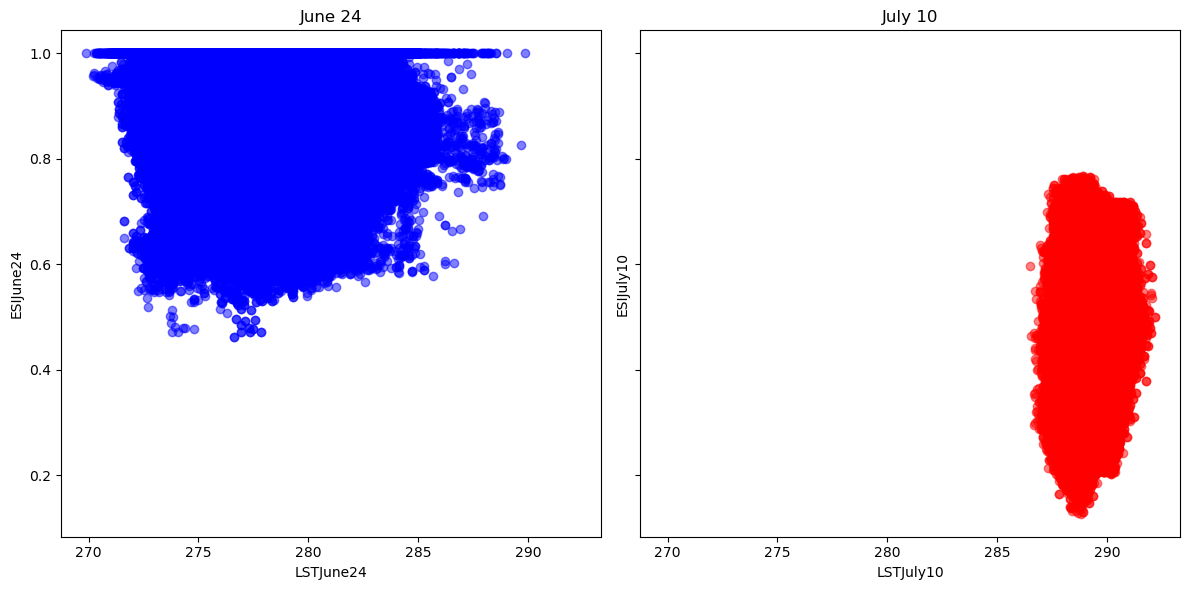

In [58]:
### Plotting with Matplotlib
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

# June scatter plot
axes[0].scatter(stack['LSTJune24'], stack['ESIJune24'], alpha=0.5, c='blue')
axes[0].set_title('June 24')
axes[0].set_xlabel('LSTJune24')
axes[0].set_ylabel('ESIJune24')

# July scatter plot
axes[1].scatter(stack['LSTJuly10'], stack['ESIJuly10'], alpha=0.5, c='red')
axes[1].set_title('July 10')
axes[1].set_xlabel('LSTJuly10')
axes[1].set_ylabel('ESIJuly10')

plt.tight_layout()
plt.show()

### How does LST and ESI vary by major fuel type?

### Is there a correlation between LST or ESI and Vapor PRessure Deficit (VPD)